# Génération de caractères 

Installation de toutes les librairies

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tf-nightly

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from datetime import datetime

!pip install -U matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

You should consider upgrading via the 'C:\Users\rmrsm\anaconda3\python.exe -m pip install --upgrade pip' command.


## Récupération du texte d'Alice auxx Pays des Merveilles

On récupère le fichier wonderland.txt qui est dans le même dossier que ce notebook 

In [5]:
filename = "wonderland"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

In [6]:
print(raw_text)

alice's adventures in wonderland

lewis carroll

the millennium fulcrum edition 3.0

chapter i. down the rabbit-hole

alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought alice 'without pictures or
conversations?'

so she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure
of making a daisy-chain would be worth the trouble of getting up and
picking the daisies, when suddenly a white rabbit with pink eyes ran
close by her.

there was nothing so very remarkable in that; nor did alice think it so
very much out of the way to hear the rabbit say to itself, 'oh dear!
oh dear! i shall be late!' (when she thought it over afterwards, it
occurred to her that she ought to have wondered at this, but at the time
it al

La liste des caractères trouvé dans le texte, qui seront les caractères à prédire.

In [28]:
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [23]:
print(chars)

['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '3', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [29]:
n_chars = len(raw_text)
n_vocab = len(chars)

On choisis de découper le texte en plusieurs portions de 100 caractères (seq_length)

In [30]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print ("Total Patterns: ", n_patterns)

Total Patterns:  144304


Traduire les caractères en vecteurs catégoriques (one hot encoding)

In [31]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

Définition du modèle

In [32]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

On définit les noms des sauvegardes, avec le jour et l'heure précise pour avoir des sauvegardes différentes  

In [33]:
# define the checkpoint

#date of the day 

now = datetime.now()
today = now.strftime("%d-%m-%Y-%H-%M")

filepath="./"+today+"/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

On entraîne le modèle

In [42]:
batch_size_choosen = 128
model.fit(X, y, epochs=4, batch_size=batch_size_choosen, callbacks=callbacks_list)

Epoch 1/4
1128/1128 [==============================] - ETA: 0s - loss: 2.4814
Epoch 1: loss improved from 2.53836 to 2.48144, saving model to ./09-05-2022-13-37\weights-improvement-01-2.4814.hdf5
1128/1128 [==============================] - 323s 286ms/step - loss: 2.4814
Epoch 2/4
1128/1128 [==============================] - ETA: 0s - loss: 2.4292
Epoch 2: loss improved from 2.48144 to 2.42919, saving model to ./09-05-2022-13-37\weights-improvement-02-2.4292.hdf5
1128/1128 [==============================] - 321s 285ms/step - loss: 2.4292
Epoch 3/4
1128/1128 [==============================] - ETA: 0s - loss: 2.3822
Epoch 3: loss improved from 2.42919 to 2.38216, saving model to ./09-05-2022-13-37\weights-improvement-03-2.3822.hdf5
1128/1128 [==============================] - 318s 282ms/step - loss: 2.3822
Epoch 4/4
1128/1128 [==============================] - ETA: 0s - loss: 2.3352
Epoch 4: loss improved from 2.38216 to 2.33522, saving model to ./09-05-2022-13-37\weights-improvement-04-

On récupère tous les taux de pertes 

In [43]:
epoch = []
loss = []
files=[f for f in listdir(today) if isfile(join(today, f))]

for i in range(0, len(files)):
    
    #récupérer le nom du fichier dans le fichier today où l'epoch sera i 
    actualFile = files[i]
    
    #on veut une chaine de caractère avec le numéro de l'epoch puis une avec le loss
    epoch.append(i)
    loss.append(float(actualFile[23:29]))

### Définition de la fonction fit_result, qui obtient les taux de pertes pour toutes les epochs 

In [12]:
# batch_size_choosen : la taille du batch_size choisi (nombre de données)
# epoch_choosen : nombre d'epoch choisi pour entrainer le model 

def fit_result(batch_size_choosen, epoch_choosen):
    
    epoch = [] #contiendra les trois cycles d'epoch 
    loss = [] #contiendra les trois cycles de loss
    len_files = [] #contiendra les 3 nombres de fichiers (un pour chaque cycle)
    
    #boucle de 3 tours pour faire une moyenne de chaque epoch obtenue 
    for i in range(3):
      model = Sequential()
      model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
      model.add(Dropout(0.2))
      model.add(Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam')
      #date et heure pour le nom du nouveau dossier 
      now = datetime.now()
      today = now.strftime("%d-%m-%Y-%H-%M")

      filepath="./"+today+"/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
      checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
      callbacks_list = [checkpoint]

      #on entraine le modele  
      model.fit(X, y, epochs=epoch_choosen, batch_size=batch_size_choosen, callbacks=callbacks_list)

      files=[f for f in listdir(today) if isfile(join(today, f))]
      epoch_cycle = []
      loss_cycle = []
      len_files.append(len(files))#nombre de fichiers créés
    
        
    
      #on va traiter un fichier après l'autre
      for j in range(0, len_files[i]):
    
        #récupérer le nom du fichier dans le fichier today où l'epoch sera i 
        actualFile = files[j]
    
        #on récupère le numéro de l'epoch et le loss
        actual_epoch = float(actualFile[20:22])
        actual_loss = float(actualFile[23:29])
        
        #on traite les epoch qui ont plusieurs fichiers 
        total_loss = actual_loss
        number_of_epoch = 1
        
        #on vérifie qu'on ne traite pas le dernier fichier 
        if (j+1) < len_files[i] : 
            
            iteration = 2
            nextFile = files[j+1]
            while actual_epoch == float(nextFile[20:22]) : 
                number_of_epoch = number_of_epoch+1
                total_loss = total_loss + float(nextFile[23:29])
                if (j+iteration) >= len_files[i] :
                    break
                else :
                    nextFile = files[j+iteration]
                    iteration = iteration +1
                    
            if number_of_epoch > 1:
                
                # on modifie j pour ne pas retraiter les mêmes fichiers 
                j = j + number_of_epoch-1 #j+ le nombre d'epoch passé
                
                #on fait la moyenne des loss pour en avoir seulement un pour cette epoch
                actual_loss = total_loss / number_of_epoch
        
        #on sauvegarde l'epoch et le loss 
        epoch_cycle.append(actual_epoch)
        loss_cycle.append(actual_loss)
        
      epoch.append(epoch_cycle)
      loss.append(loss_cycle)
        
    #moyenne des 3 cycles par epoch 
    #on prend tous ceux qui sont de epoch = 1 et on en fait une moyenne 
    epoch_buffer = []
    epoch_mean = []
    loss_buffer = []
    loss_mean = []
    

    for j in range(0, epoch_choosen):

        for k in range(3):
            loss_buffer.append(loss[k][j])
        epoch_mean.append(j+1)
        loss_mean.append(np.mean(loss_buffer))
    
    results = pd.DataFrame()
    results['epoch']=epoch_mean
    results['loss']=loss_mean
    
    return results 

### On lance fit_result pour différents batch size et affiche les résultats dans un plot

In [71]:
results32 = fit_result(32, 10)
results64 = fit_result(64, 10)
results128 = fit_result(128, 10)

Epoch 1/10
4510/4510 [==============================] - ETA: 0s - loss: 2.8742
Epoch 1: loss improved from inf to 2.87424, saving model to ./10-05-2022-01-28\weights-improvement-01-2.8742.hdf5
4510/4510 [==============================] - 816s 180ms/step - loss: 2.8742
Epoch 2/10
4510/4510 [==============================] - ETA: 0s - loss: 2.6713
Epoch 2: loss improved from 2.87424 to 2.67131, saving model to ./10-05-2022-01-28\weights-improvement-02-2.6713.hdf5
4510/4510 [==============================] - 817s 181ms/step - loss: 2.6713
Epoch 3/10
4510/4510 [==============================] - ETA: 0s - loss: 2.5592
Epoch 3: loss improved from 2.67131 to 2.55916, saving model to ./10-05-2022-01-28\weights-improvement-03-2.5592.hdf5
4510/4510 [==============================] - 814s 180ms/step - loss: 2.5592
Epoch 4/10
4510/4510 [==============================] - ETA: 0s - loss: 2.4709
Epoch 4: loss improved from 2.55916 to 2.47087, saving model to ./10-05-2022-01-28\weights-improvement-04-

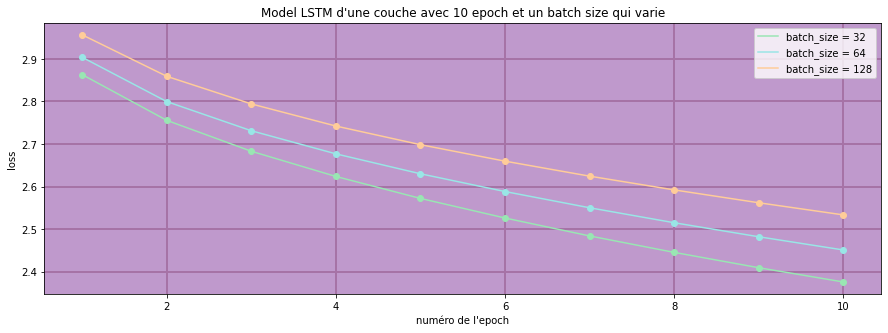

In [72]:

plt.figure(figsize=(15,5))
plt.axes().set(facecolor=(.75,.6,.8,1.))
plt.plot(results32['epoch'], results32['loss'], color=(.6,.9,.7,1.),label='batch_size = 32')
plt.plot(results32['epoch'], results32['loss'],'o', color=(.6,.9,.7,1.))

plt.plot(results64['epoch'], results64['loss'], color=(.6,.9,.9,1.),label='batch_size = 64')
plt.plot(results64['epoch'], results64['loss'],'o', color=(.6,.9,.9,1.))

plt.plot(results128['epoch'], results128['loss'], color=(1.,0.8,.6,1.),label='batch_size = 128')
plt.plot(results128['epoch'], results128['loss'],'o', color=(1.,0.8,.6,1.))

plt.legend()
plt.xlabel("numéro de l'epoch")
plt.ylabel("loss")
#plt.ylim(0.7,1.01)
plt.grid(axis="both", linewidth=2, color=(.65,.45,.65,1.))
title = "Model LSTM d'une couche avec 10 epoch et un batch size qui varie"
plt.title(title)

plt.show()

# Génération de texte avec le réseau LSTM

On va maintenant prendre le poids le plus petit parmis ceux sauvegardés, ici le fichier : weights-improvement-04-2.4580.hdf5

In [34]:
# load the network weights
#"epoch10batchsize3264128/10-05-2022-03-44/weights-improvement-10-2.0575.hdf5"
filename = "weights-improvement-04-2.4580.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [35]:
#Création de la liste de caractères (pas en entiers) pour comprendre les prédictions
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [36]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
print("\n next : \n\n")
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	print(result, end="")#sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print ("\nDone.")

Seed:
" res
of her little sister's dream.

the long grass rustled at her feet as the white rabbit hurried by "

 next : 


 the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the whe sar at the wh

#### Ajout d'une seconde couche au réseaux !

In [15]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

Une petite augmentation de 4 à 6 epoch
On le ré entraine 

In [37]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
model.fit(X, y, epochs=6, batch_size=64, callbacks=callbacks_list)

Epoch 1/6
2255/2255 [==============================] - ETA: 0s - loss: 2.4135
Epoch 1: loss improved from inf to 2.41348, saving model to weights-improvement-01-2.4135-bigger.hdf5
2255/2255 [==============================] - 447s 197ms/step - loss: 2.4135
Epoch 2/6
2255/2255 [==============================] - ETA: 0s - loss: 2.4327
Epoch 2: loss did not improve from 2.41348
2255/2255 [==============================] - 448s 199ms/step - loss: 2.4327
Epoch 3/6
2255/2255 [==============================] - ETA: 0s - loss: 2.3643
Epoch 3: loss improved from 2.41348 to 2.36432, saving model to weights-improvement-03-2.3643-bigger.hdf5
2255/2255 [==============================] - 452s 200ms/step - loss: 2.3643
Epoch 4/6
2255/2255 [==============================] - ETA: 0s - loss: 2.2966
Epoch 4: loss improved from 2.36432 to 2.29665, saving model to weights-improvement-04-2.2966-bigger.hdf5
2255/2255 [==============================] - 457s 203ms/step - loss: 2.2966
Epoch 5/6
2255/2255 [======

On garde seulement le fichier avec le plus petit loss c'est à dire : 
le plus petit trouvé a été weights-improvement-06-1.9275-bigger.hdf5

In [21]:
# load the network weights
filename = "weights-improvement-06-1.9275-bigger.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	print(result, end="")#sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" r places--all,' he repeated with
great emphasis, looking hard at alice as he said do.

alice looked  "
to alice and the cooroe, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook taid to all the courte, and the mook 